In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

2026-02-02 23:55:52.320719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-02 23:55:52.363074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-02 23:55:53.848718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [ ]:
print(tf.__version__)

In [2]:
batch_size = 32
img_height = 96
img_width = 96

directory = os.path.join(os.getcwd(),"data", "training")

In [3]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for training and validation
    subset = "training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    validation_split = 0.2, #20% of data is used for testing results
    subset = "validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 15244 files belonging to 9 classes.
Using 12196 files for training.


2026-02-02 23:55:55.665518: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 15244 files belonging to 9 classes.
Using 3048 files for validation.


In [4]:
class_names = training_ds.class_names
print(f"Categories: {class_names}")

Categories: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

# cache(): Keeps images in memory after the first epoch (speeds up disk I/O)
# shuffle(): Re-shuffles the training data every epoch
# prefetch(): Prepares the next batch while the model is training on the current one
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
found_images = {}
num_classes = len(class_names)

for images, labels in training_ds:
    for i in range(len(labels)):
        class_idx = labels[i].numpy()
        if class_idx not in found_images:
            found_images[class_idx] = images[i].numpy().astype("uint8")
        if len(found_images) == num_classes:
            break
    if len(found_images) == num_classes:
        break

plt.figure(figsize=(12, 12))
for i, class_idx in enumerate(sorted(found_images.keys())):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(found_images[class_idx])
    plt.title(class_names[class_idx])
    plt.axis("off")

plt.show()

In [6]:
#without augmentation the model was overfitting even getting worse on 
# validation data with loss doubling from epoch 3 to epoch 10

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

/home/cemil/NodeProjects/Sorti/.venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in training_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) # Show 9 variations of same img
        plt.axis("off")
plt.show()

In [ ]:
# Run 1 simple CNN 128x128

num_classes = len(class_names)

model = tf.keras.Sequential([

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)
    tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
#adam is teacher that adjusts weights and biases, loss is grading scale for accuracy
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 20

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#Run 2 add dropout to fight overfitting and data augmentation double epochs

num_classes = len(class_names)

model = tf.keras.Sequential([
    #layer0 makes training harder by using augmentation
    data_augmentation,

    #Layer 1: Rescaling
    tf.keras.layers.Rescaling(1./255),
    #LAyer2 : Kernel/Feature Finder
    tf.keras.layers.Conv2D(16,3, padding="same", activation="relu"),
    #Layer 3: Compressor (Shrinks feature maps from kernel)
    tf.keras.layers.MaxPooling2D(),

    #layer 4 & 5 (more filters for more complex patterns)
    tf.keras.layers.Conv2D(32,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64,3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    #lyer 6: flatten
    tf.keras.layers.Flatten(),

    #layer 7: Dense 128 Neurons("make sense" of flattened list)
    tf.keras.layers.Dense(128,activation="relu"),
    #layer 8: outputs 8 numbers (highest number is models guess)

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)

epochs = 40

history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy ({epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss ({epochs} epochs)')

plt.show()

In [ ]:
#run 3 (bigger model, added batchnormalization and more layers, increased epochs to 100 and callbacks and regularization)

#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    # Dense Block (The Classifier)
    # Note: We stick to 1-2 dense layers for CNNs to avoid parameter explosion
    tf.keras.layers.Dense(512, use_bias=False, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])

model.summary()


In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

In [7]:
#RUN 4 Reduce Filters to tackle Ressource Problems reduce image size to 96x96
#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False, 
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Flatten(),
    
    # Dense Block (The Classifier)
    # Note: We stick to 1-2 dense layers for CNNs to avoid parameter explosion
    tf.keras.layers.Dense(256, use_bias=False, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             

 Total params: 458,729 (1.75 MB)

 Trainable params: 457,257 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 103s 259ms/step - accuracy: 0.3349 - loss: 2.4409 - val_accuracy: 0.2657 - val_loss: 2.5386
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 95s 250ms/step - accuracy: 0.4302 - loss: 2.0386 - val_accuracy: 0.2533 - val_loss: 2.9046
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 96s 251ms/step - accuracy: 0.4633 - loss: 1.8443 - val_accuracy: 0.4623 - val_loss: 1.8562
Epoch 4/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 96s 252ms/step - accuracy: 0.4881 - loss: 1.6997 - val_accuracy: 0.3058 - val_loss: 2.3921
Epoch 5/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 95s 248ms/step - accuracy: 0.5123 - loss: 1.6232 - val_accuracy: 0.4127 - val_loss: 1.8218
Epoch 6/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 92s 240ms/step - accuracy: 0.5271 - loss: 1.5590 - val_accuracy: 0.4636 - val_loss: 1.8135
Epoch 7/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 91s 239ms/step - accuracy: 0.5507 - loss: 1.5115 - val_accuracy: 0.3743 - val_loss: 2.1111
Epoch 8/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 91s 239ms/step - accuracy: 0.5622 

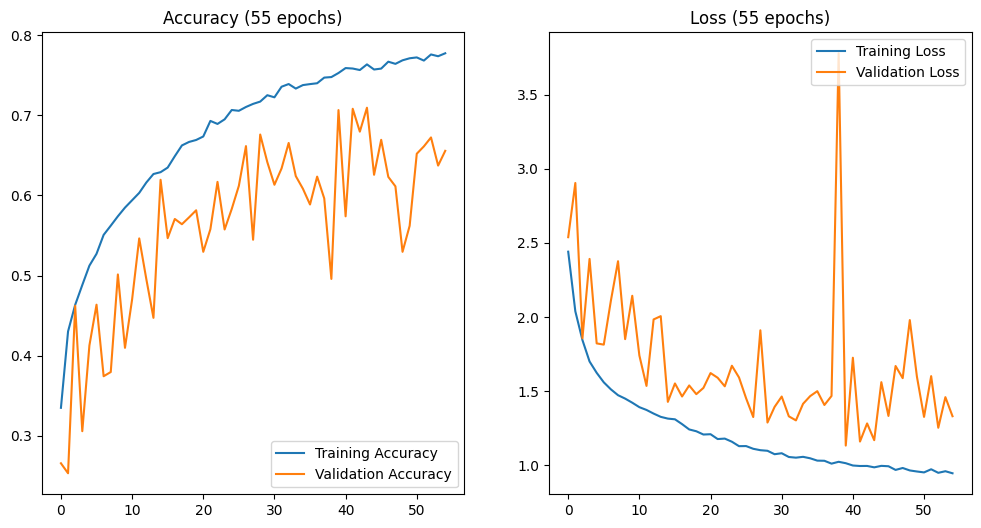

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

In [11]:
#RUN 5 Go back to 5 Block Architecture
#setup callbacks
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True
)

my_callbacks = [tensorboard_callback, early_stopping_callback]

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    
    # Conv Block 1
    tf.keras.layers.Conv2D(32, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 2
    tf.keras.layers.Conv2D(64, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 3
    tf.keras.layers.Conv2D(128, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 4
    tf.keras.layers.Conv2D(256, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    # Conv Block 5
    tf.keras.layers.Conv2D(512, 3, padding="same", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    # Dense Block (The Classifier)
    # Note: We stick to 1-2 dense layers for CNNs to avoid parameter explosion
    tf.keras.layers.Dense(512, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 96, 96, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 48, 48, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 6, 6, 512)      │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,840,361 (7.02 MB)

 Trainable params: 1,837,353 (7.01 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

epochs = 100
history = model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=my_callbacks
)

Epoch 1/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 122s 314ms/step - accuracy: 0.2566 - loss: 7.8341 - val_accuracy: 0.1634 - val_loss: 3.8901
Epoch 2/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 118s 310ms/step - accuracy: 0.2573 - loss: 3.1480 - val_accuracy: 0.1873 - val_loss: 3.1587
Epoch 3/100
382/382 ━━━━━━━━━━━━━━━━━━━━ 138s 362ms/step - accuracy: 0.2713 - loss: 2.7676 - val_accuracy: 0.0541 - val_loss: 6.2835
Epoch 4/100
176/382 ━━━━━━━━━━━━━━━━━━━━ 1:04 311ms/step - accuracy: 0.2756 - loss: 2.6662

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Accuracy ({actual_epochs} epochs)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Loss ({actual_epochs} epochs)')
plt.show()

#____EMD OF RUNS____

In [ ]:
model_filename = 'run_3.keras'

In [ ]:
model.save(model_filename)

In [ ]:
#CREATING CONFUSION MATRIX

import numpy as np

loaded_model = tf.keras.models.load_model(model_filename)

y_true = []
y_pred = []

for images, labels in validation_ds:
    predictions = loaded_model.predict(images, verbose=0)

    #argmax to pick index of highest number
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# 1. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 2. Plot it as a Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix: Where is the model confused?')
plt.ylabel('True Label (Truth)')
plt.xlabel('Predicted Label (Model Guess)')
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit